In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy
from scipy.stats import shapiro, boxcox
from statsmodels.stats.api import (het_breuschpagan,
                                   het_goldfeldquandt,
                                   het_white, jarque_bera,
                                   omni_normtest, normal_ad)
from statsmodels.stats.diagnostic import kstest_normal, normal_ad
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.formula.api import ols
from statsmodels.tools.tools import add_constant
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad
from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")

In [35]:
def is_normal(dataset, test, p_level=0.05):
    stat, pval = test
    return 'dataset {}, test {}: Normal'.format(dataset, test) if pval < p_level else 'Not Normal'

def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
    
def tsplot(y, lags=None, figsize=(12, 7), style='bmh', d_name=None):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        p_value = sm.tsa.stattools.adfuller(y)[1]
        if p_value >0.05:
            l_text = 'Ряд для {} не является стационарным'.format(d_name)
        else:
            l_text = 'Ряд для {} является стационарным'.format(d_name) 

        y.plot(ax=ts_ax, label=l_text)
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        ts_ax.legend()

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()


def diff_series(dataset):
    dataset['y_diff'] = dataset.y_diff.diff().dropna()
    test = sm.tsa.adfuller(dataset.y_diff.dropna())
    return test

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [36]:
df = pd.read_csv('/home/mikhail/it-academy/модуль 7/data.csv',sep=',')#, index_col=['dt'], parse_dates=['dt'])
df.columns = ['ds', 'y']
df_indexed = df
df_indexed['ds'] = pd.to_datetime(df_indexed['ds'])
df_indexed = df_indexed.pivot_table(index="ds")
#df_indexed.index.freq ='3T'
print('df_indexed общая информация: ')
print(df_indexed.info())
print(df_indexed.describe())
print(df_indexed.shape)

df_indexed общая информация: 
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 385516 entries, 2011-01-01 00:00:00 to 2021-12-30 07:45:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   y       385516 non-null  float64
dtypes: float64(1)
memory usage: 5.9 MB
None
                   y
count  385516.000000
mean     3183.379344
std      3045.815396
min         0.000000
25%       905.000000
50%      2164.000000
75%      4529.285000
max     16727.500000
(385516, 1)


In [37]:
print('Не везде измерения снимались с интервалом в 15 мин')
last=pd.to_datetime('2011-01-01 00:00:00')
i=2
for index in df_indexed.index:
    if ((index - last).to_numpy()/1000000000).item() == 900:
        pass
    else:
        print(i, index, last)
    last = index
    i+=1

Не везде измерения снимались с интервалом в 15 мин
2 2011-01-01 00:00:00 2011-01-01 00:00:00
8170 2011-03-27 03:00:00 2011-03-27 01:45:00
43110 2012-03-25 03:00:00 2012-03-25 01:45:00
78722 2013-03-31 03:00:00 2013-03-31 01:45:00
113662 2014-03-30 03:00:00 2014-03-30 01:45:00
114432 2014-04-07 03:45:00 2014-04-07 03:15:00
121580 2014-06-20 15:00:00 2014-06-20 14:30:00
121582 2014-06-20 15:45:00 2014-06-20 15:15:00
122045 2014-06-25 11:45:00 2014-06-25 11:15:00
122053 2014-06-25 14:00:00 2014-06-25 13:30:00
122054 2014-06-25 14:30:00 2014-06-25 14:00:00
148596 2015-03-29 03:00:00 2015-03-29 01:45:00
183536 2016-03-27 03:00:00 2016-03-27 01:45:00
218476 2017-03-26 03:00:00 2017-03-26 01:45:00
253416 2018-03-25 03:00:00 2018-03-25 01:45:00
277069 2018-11-26 12:45:00 2018-11-26 12:00:00
289026 2019-03-31 03:00:00 2019-03-31 01:45:00
323966 2020-03-29 03:00:00 2020-03-29 01:45:00
358906 2021-03-28 03:00:00 2021-03-28 01:45:00


dataset df, test ShapiroResult(statistic=0.8477106094360352, pvalue=0.0): Normal
dataset df, test NormaltestResult(statistic=92623.76873662391, pvalue=0.0): Normal
dataset df, test (17723.625109848683, 0.0): Normal
dataset df, test (0.14797338137528804, 0.0009999999999998899): Normal
dataset df, test KstestResult(statistic=0.14797306817802597, pvalue=0.0): Normal


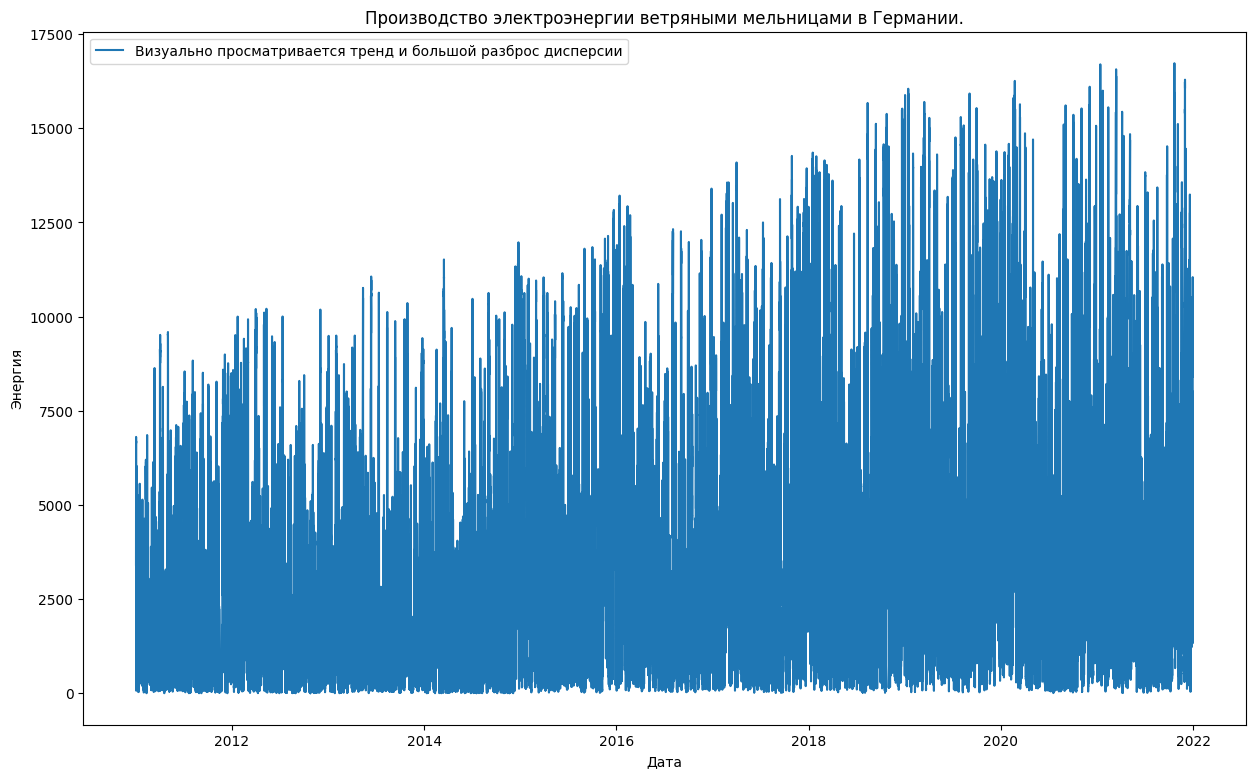

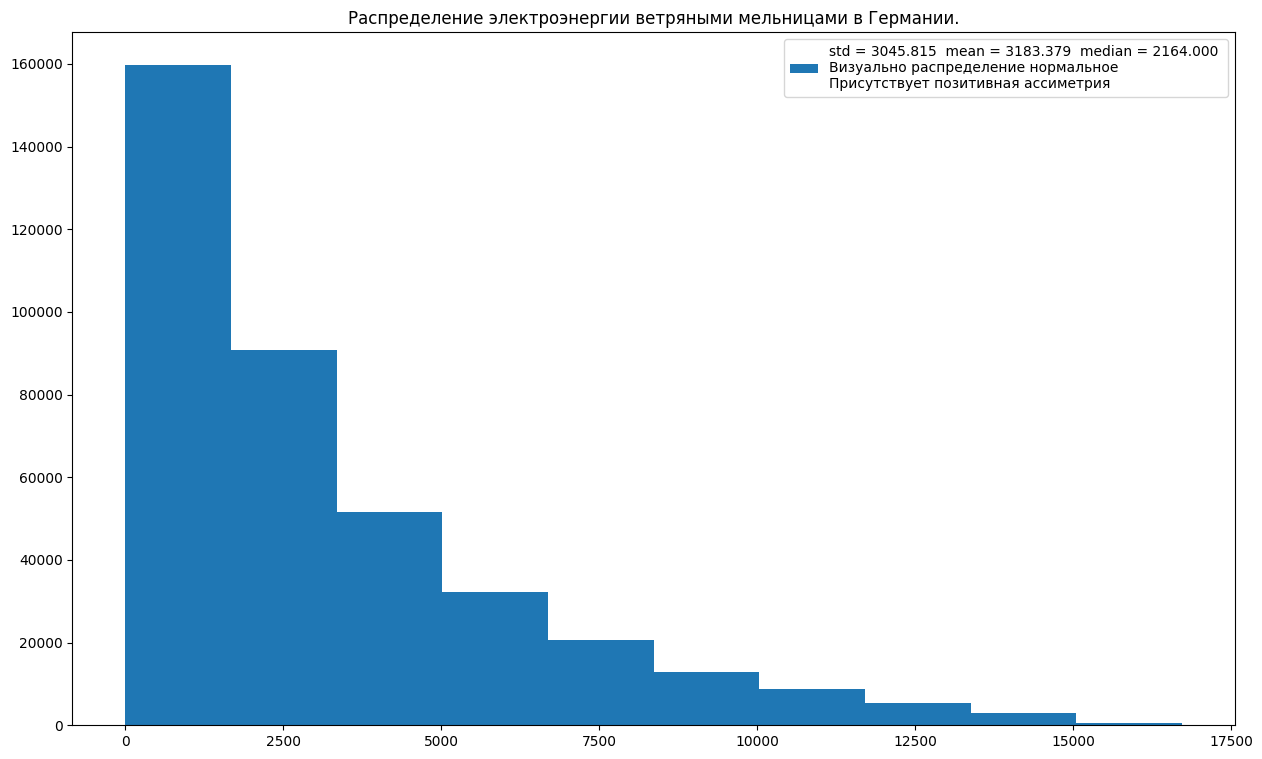

In [38]:
#строим граффик
fig1, ax1 = plt.subplots(figsize=(15,9))
ax1.plot(df_indexed.index, df_indexed.y, label='Визуально просматривается тренд')
ax1.set_xlabel('Дата')
ax1.set_ylabel('Энергия')
ax1.set_title('Производство электроэнергии ветряными мельницами в Германии.');
plt.legend()

#смотрим распределение
normal_args = (np.mean(df_indexed.y),np.std(df_indexed.y))

print(is_normal('df',shapiro(df_indexed.y)))
print(is_normal('df', normaltest(df_indexed.y)))
print(is_normal('df', normal_ad(df_indexed.y)))
print(is_normal('df', kstest_normal(df_indexed.y)))
print(is_normal('df', kstest(df_indexed.y,
                    cdf='norm',
                    args=normal_args)))

fig2, ax2 = plt.subplots(figsize=(15,9))
ax2.hist(df_indexed.y,label='std = {:.3f}  mean = {:.3f}  median = {:.3f} \nВизуально распределение нормальное\nПрисутствует позитивная ассиметрия'.format(df_indexed.y.std(),df_indexed.y.mean(),df_indexed.y.median()))
ax2.set_title('Распределение электроэнергии ветряными мельницами в Германии.')
plt.legend()


df_indexed общая информация: 
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 575 entries, 2011-01-02 to 2022-01-02
Freq: W-SUN
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       575 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB
None
                  y
count    575.000000
mean    2626.694887
std     1759.379963
min      169.500000
25%     1439.540000
50%     2189.500000
75%     3446.480000
max    12063.960000
(575, 1)


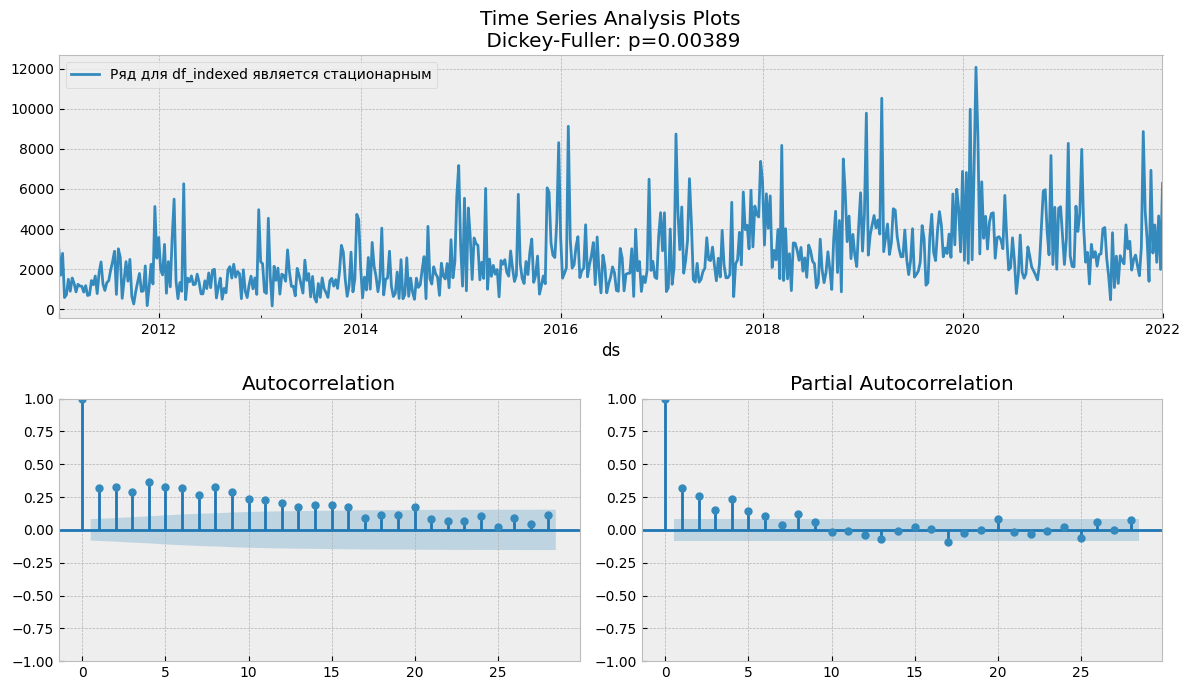

In [39]:
#Усредняем за неделю, чтобы избавиться от пропущенных значений
df_indexed = df_indexed.resample(rule='W').median() 
print('df_indexed общая информация: ')
print(df_indexed.info())
print(df_indexed.describe())
print(df_indexed.shape)
#удалил строки с Nan начениями 
#df_indexed = df_indexed.dropna()
#print(df_indexed.info())
#print(df_indexed.shape)
tsplot(df_indexed.y,d_name='df_indexed')

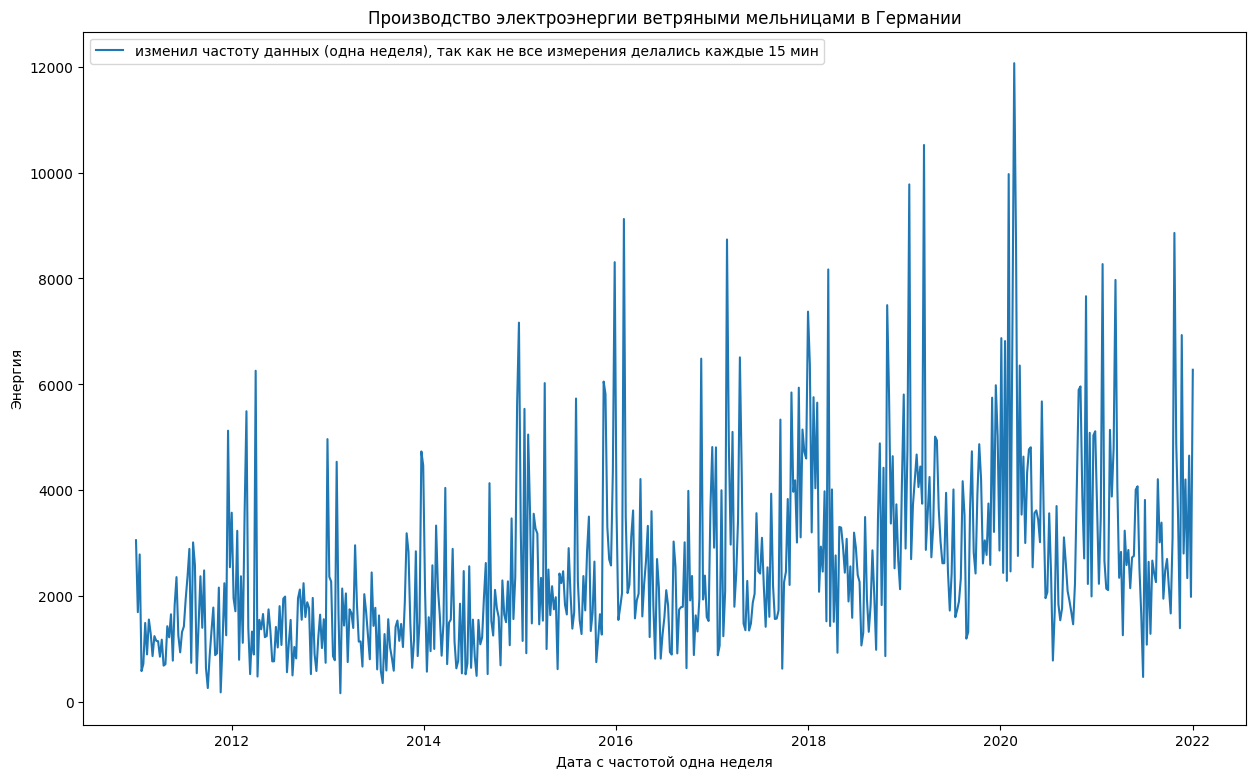

In [40]:
fig3, ax3 = plt.subplots(figsize=(15,9))
ax3.plot(df_indexed.index, df_indexed.y, label='изменил частоту данных (одна неделя), так как не все измерения делались каждые 15 мин')
ax3.set_xlabel('Дата с частотой одна неделя')
ax3.set_ylabel('Энергия')
ax3.set_title('Производство электроэнергии ветряными мельницами в Германии');
plt.legend()

разложение ряда на компоненты говорит, что тренд и сезонность присутствует


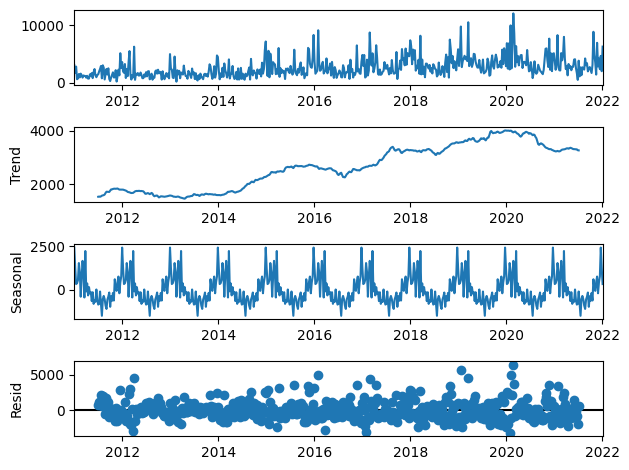

In [41]:
seasonal_decompose(df_indexed, model='additive').plot()
print('разложение ряда на компоненты говорит, что тренд и сезонность присутствует')

In [42]:
"""
print('Дифференцирование ряда для преобразования его в стационарный ряд: ')
df_indexed['y_diff'] = df_indexed.y

stat_series = False
n_diff = 0
for n in range(10):
    n_diff += 1
    test = diff_series(df_indexed)
    if test[0] < test[4]['5%']: 
        stat_series = True
        break;

print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if stat_series == True:
    fig9, ax9 = plt.subplots(figsize=(10,5))
    ax9.plot(df_indexed.y_diff,color='red',label='после {} дифференцирований ряд стал стационарным, p_value={:.3f}'.format(n_diff, test[1]))
    ax9.set_xlabel('Временной дифференцированный ряд с интервалом один месяц')
    ax9.set_ylabel('Средняя цена закрытия за месяц')
    ax9.set_title('Газпром ПАО')
    plt.legend()
else:
    fig9, ax9 = plt.subplots(figsize=(10,5))
    ax9.plot(df_indexed.y_diff,color='red',label='после {} дифференцирований ряд по прежнему не стационарный, p_value={:.3f}'.format(n, test[1]))
    ax9.set_xlabel('Временной дифференцированный ряд с интервалом один месяц')
    ax9.set_ylabel('Средняя цена закрытия за месяц')
    ax9.set_title('Газпром ПАО')
    plt.legend() 
"""

"\nprint('Дифференцирование ряда для преобразования его в стационарный ряд: ')\ndf_indexed['y_diff'] = df_indexed.y\n\nstat_series = False\nn_diff = 0\nfor n in range(10):\n    n_diff += 1\n    test = diff_series(df_indexed)\n    if test[0] < test[4]['5%']: \n        stat_series = True\n        break;\n\nprint('adf: ', test[0])\nprint('p-value: ', test[1])\nprint('Critical values: ', test[4])\nif stat_series == True:\n    fig9, ax9 = plt.subplots(figsize=(10,5))\n    ax9.plot(df_indexed.y_diff,color='red',label='после {} дифференцирований ряд стал стационарным, p_value={:.3f}'.format(n_diff, test[1]))\n    ax9.set_xlabel('Временной дифференцированный ряд с интервалом один месяц')\n    ax9.set_ylabel('Средняя цена закрытия за месяц')\n    ax9.set_title('Газпром ПАО')\n    plt.legend()\nelse:\n    fig9, ax9 = plt.subplots(figsize=(10,5))\n    ax9.plot(df_indexed.y_diff,color='red',label='после {} дифференцирований ряд по прежнему не стационарный, p_value={:.3f}'.format(n, test[1]))\n    

01:16:14 - cmdstanpy - INFO - Chain [1] start processing
01:16:14 - cmdstanpy - INFO - Chain [1] done processing


(575, 2) (527, 2) (48, 2) (623, 16)


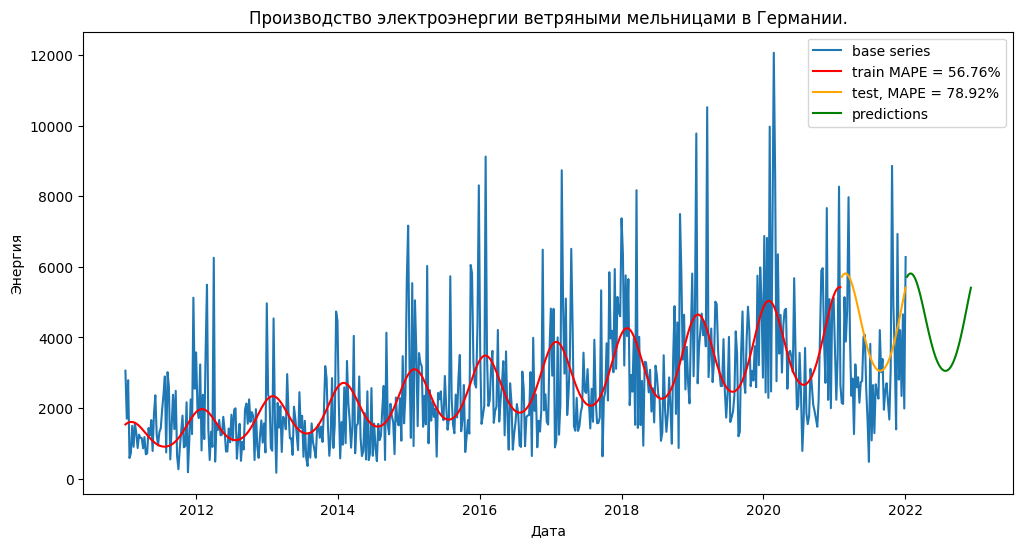

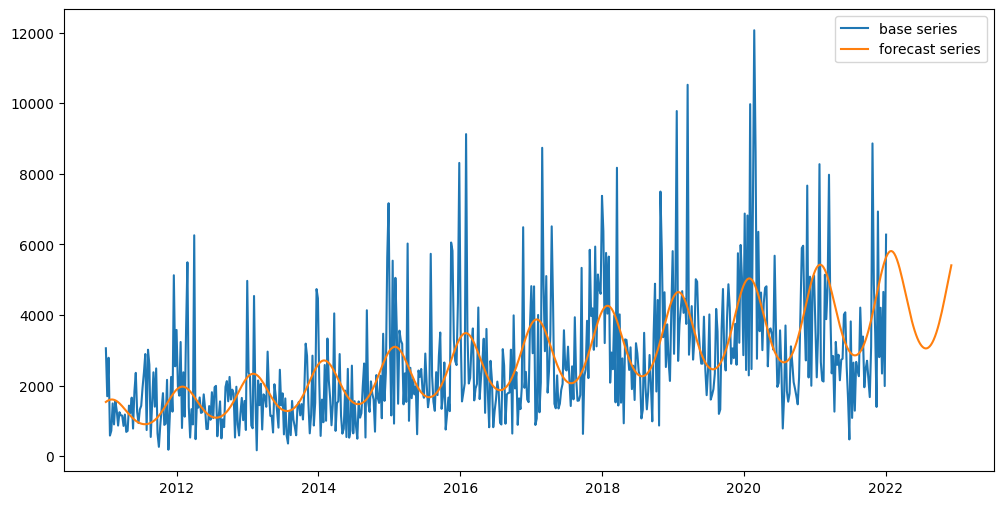

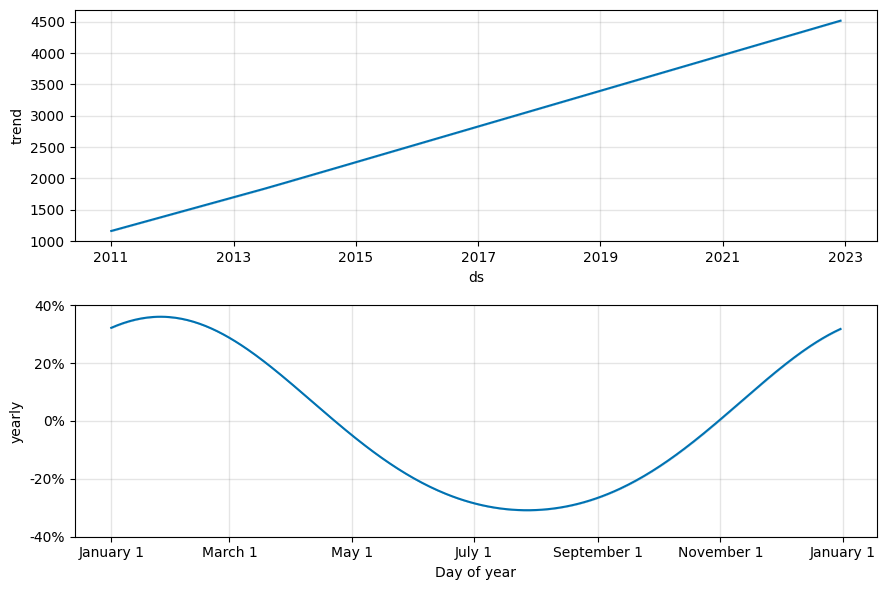

In [43]:
#Добавим колонку ds, так как модель Prophet работает с ds и y
df_indexed['ds'] = df_indexed.index
predictions = 48
train_df = df_indexed.iloc[:-predictions] 
test_df = df_indexed.iloc[-predictions:]


model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=2)

model.fit(train_df)

future = model.make_future_dataframe(periods=predictions+predictions, freq='W') #так как усредняли за неделю, в месяце 4 недели, необходимо сделать прогноз на 12 мес, 4*12
forecast = model.predict(future)
print(df_indexed.shape, train_df.shape, test_df.shape, forecast.shape)

error_train = mean_absolute_percentage_error(train_df.y.values, forecast[:train_df.shape[0]].yhat.values)
error_test = mean_absolute_percentage_error(test_df.y.values, forecast[-test_df.shape[0]:].yhat.values)
#print(error_train, error_test)

fig1, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df_indexed.index, df_indexed.y, label='base series')
ax1.plot(train_df.index, forecast[:train_df.shape[0]].yhat.values, c='red', label='train MAPE = {:.2f}%'.format(error_train))
ax1.plot(test_df.index, forecast[-test_df.shape[0]:].yhat.values, c='orange', label='test, MAPE = {:.2f}%'.format(error_test))
ax1.plot(forecast[train_df.shape[0]+test_df.shape[0]:].ds, forecast[train_df.shape[0]+test_df.shape[0]:].yhat.values, c='green', label='predictions')
ax1.set_xlabel('Дата')
ax1.set_ylabel('Энергия')
ax1.set_title('Производство электроэнергии ветряными мельницами в Германии.');
plt.legend()

fig2, ax2 = plt.subplots(figsize=(12,6))
ax2.plot(df_indexed.index, df_indexed.y, label='base series')
ax2.plot(forecast.ds, forecast.yhat.values, label='forecast series')
ax1.set_xlabel('Дата')
ax1.set_ylabel('Энергия')
ax1.set_title('Производство электроэнергии ветряными мельницами в Германии.');
plt.legend()

fig_2 = model.plot_components(forecast)
plt.show()

##Вывод

Этот ряд обладает нарастающим трендом и сезонностью. Гистограмма распределений и статистические тесты говорят о том, что распределение данных нормальное с позитивной ассиметрией. Тест Дики-Фуллера говорит, что ряд стационарный (что странно потому что ряд имеет тренд и сезонность). Для прогнозирования ряда я использовал модель Prophet потому что эта библиотека очень удобна и экономит много времени для прогнозирования ряда. Prophet прекрасно справляется с рядами, обладающих трендом, дисперсией и сезонностью. Так же эта модель работает быстрее чем в SARIMA подбирать лучшие комбинации параметров p,q,P,Q. Поскольку ряд стационарный и влияние дисперсии невелико, то в моделях ARCH и GARCH нет необходимости. Ряд имеет сезонность значит ARIMA не подойдет.
На граффике тенденции и сезонности мы видим, что производство электроэнергии ветряными мельницами в Германии растест с каждым годом линейно, а годовая сезонность говорит, что спад производства (и потребления) электроэнергии приходится с конца весны и по начало осени (летом нет необходимости в большом количестве электроэнергии). На граффике видно, что прогноз учитывает тенденцию и сезонную составляющую ряда.